In [16]:
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import pickle

In [17]:
pd.set_option('display.max_columns', None)

In [18]:
fifa21 = pd.read_csv('fifa21_train.csv')

**1: cleaning the data**

**2 Step: we are going to write a function which:**

**takes a dataframe as input
perform the data cleaning operations on the assigned columns
return a new cleaned dataframe.
Then put all you group member functions into the group jupyter notebook**

In [19]:
def fifa_cleaner(x):
    
    #change column names 
    columns = []
    for col in x.columns: 
        if ' ' in col:
            col = col.replace(' ','_')
            columns.append(col.lower())
        else:
            columns.append(col.lower())
            
    x.columns = columns
    
    #dropping unnecesary columns
    
    x = x.drop(columns = ['id','name','nationality','club', 'position', 'attacking', 'skill', 'movement', 'total_stats', 'base_stats', 'goalkeeping', 'defending', 'power', 'mentality', 'team_&_contract','growth','joined','loan_date_end','wage','contract','ir', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk'],axis=1)
    
    #treat unnecesary mistakes
    
    #replace the stars simbols
    x['w/f'] = x['w/f'].str.replace('★', '')
    x['sm'] = x['sm'].str.replace('★', '')
    
    
    #replace the €, M of millions and K of thousand in different columns
    x['value'] = x['value'].str.replace(".","")
    x['value'] = x['value'].str.replace("€","")
    x['value'] = x["value"].str.replace("K","000")
    x['value'] = x["value"].str.replace("M","000000")
    x['value'] = x['value'].astype(int)
    
    x['release_clause'] = x['release_clause'].str.replace(".","")
    x['release_clause'] = x['release_clause'].str.replace("€","")
    x['release_clause'] = x["release_clause"].str.replace("K","000")
    x['release_clause'] = x["release_clause"].str.replace("M","000000")
    x['release_clause'] = x['release_clause'].astype(int)
    
    #Replace + and * in entire dataframe
    x = x.replace('\+.*','',regex=True)
    
    #Replace in Hit column K for thousand
    x['hits'] = x['hits'].str.replace(".","")
    x['hits'] = x['hits'].str.replace("€","")
    x['hits'] = x["hits"].str.replace("K","000")
    x['hits'] = x["hits"].str.replace("M","000000")
    x['hits'] = x['hits'].astype(int)
    
    #Change w/f,sm to numerical
    cols=['w/f','sm']
    x[cols] = x[cols].apply(pd.to_numeric)
    
    
    
    #transform columns
    
    #change height to cm
    x['height_feet']= x['height'].str.split("'",n=2, expand=True)[0]
    x['height_inches'] = x['height'].str.split("'",n=2, expand=True)[1]
    x['height_inches'] = x['height_inches'].str.replace('"', '')
    x['height_feet'] = x['height_feet'].astype(int)
    x['height_inches'] = x['height_inches'].astype(int)
    x['height'] = (x['height_feet']*30.48) + (x['height_inches']*2.54)
    x = x.drop(columns=['height_feet', 'height_inches'])
    
    
    #change weight to kg
    x['weight'] = x['weight'].str.replace('lbs', '')
    x['weight'] = pd.to_numeric(x['weight'])
    x['weight'] = x['weight']*0.45
    
    
    
    
    #change data types
    
    
    #treat cat nans
    
    #replace NaN values in categorical with  most commun one
    x['foot'] = x['foot'].fillna('Right')
    x['a/w'] = x['a/w'].fillna('Medium')
    x['d/w'] = x['d/w'].fillna('Medium')
    
    
    #treat numerical nans
    
    #replace NaN values in numerical with  mean/media
    
    drop_list = ['age','value','release_clause','crossing','finishing','heading_accuracy','short_passing','volleys','dribbling','curve','fk_accuracy','long_passing','ball_control','acceleration','sprint_speed','agility','reactions', 'balance', 'jumping', 'interceptions', 'positioning', 'vision', 'composure', 'sliding_tackle']
    
    
    for i in drop_list:
        x[i] = x[i].fillna(x[i].mean())
        
    
    return x
    

In [20]:
 fifa21

,ID,Name,Age,Nationality,Club,BP,Position,Team & Contract,Height,Weight,foot,Growth,Joined,Loan Date End,Value,Wage,Release Clause,Contract,Attacking,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Skill,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Movement,Acceleration,Sprint Speed,Agility,Reactions,Balance,Power,Shot Power,Jumping,Stamina,Strength,Long Shots,Mentality,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defending,Marking,Standing Tackle,Sliding Tackle,Goalkeeping,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Total Stats,Base Stats,W/F,SM,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,OVA
0,184383,A. Pasche,26,Switzerland,FC Lausanne-Sport,CM,CM CDM,FC Lausanne-Sport 2015 ~ 2020,"5'9""",161lbs,Right,1,"Jul 1, 2015",NaN,€525K,€4K,€801K,2015 ~ 2020,258,54,47,43,70,44.0,286,61,44.0,55,63,63,346,64,73,61.0,66,82.0,306,62,73.0,71,55,45,290,54,52.0,62.0,68.0,54,54.0,148,49,56,43.0,48,7,12,14,9,6,1682,357,4 ★,2★,High,Medium,1 ★,69,51,63,63,51,60,3,58+1,58+1,58+1,61+0,62+0,62+0,62+0,61+0,63+1,63+1,63+1,63+1,63+1,63+1,63+1,63+1,59+1,59+1,59+1,59+1,59+1,58+1,54+1,54+1,54+1,58+1,15+1,64
1,188044,Alan Carvalho,30,China PR,Beijing Sinobo Guoan FC,ST,ST LW LM,"Beijing Sinobo Guoan FC Dec 31, 2020 On Loan","6'0""",159lbs,Right,0,"Jan 16, 2015","Dec 31, 2020",€8.5M,€23K,€0,"Dec 31, 2020 On Loan",365,66,79,76,68,76.0,375,83,78.0,72,63,79,404,83,83,88.0,75,75.0,372,74,81.0,75,74,68,313,54,33.0,78.0,72.0,76,70.0,77,35,20,22.0,55,11,7,14,7,16,1961,412,3 ★,4★,High,Low,2 ★,83,75,68,82,33,71,44,77+0,77+0,77+0,77+0,77+0,77+0,77+0,77+0,76+1,76+1,76+1,76+1,68+2,68+2,68+2,76+1,57+2,53+2,53+2,53+2,57+2,53+2,48+2,48+2,48+2,53+2,18+2,77
2,184431,S. Giovinco,33,Italy,Al Hilal,CAM,CAM CF,Al Hilal 2019 ~ 2022,"5'4""",134lbs,Right,0,"Jan 31, 2019",NaN,€9M,€49K,€15.3M,2019 ~ 2022,336,73,76,34,78,75.0,424,85,89.0,91,74,85,424,84,76,93.0,78,93.0,308,79,34.0,75,42,78,332,75,26.0,80.0,78.0,73,82.0,80,23,29,28.0,21,6,3,6,3,3,1925,404,4 ★,4★,High,Medium,2 ★,80,77,78,86,27,56,73,73+2,73+2,73+2,80+0,79+0,79+0,79+0,80+0,80+0,80+0,80+0,79+1,74+2,74+2,74+2,79+1,59+2,56+2,56+2,56+2,59+2,53+2,41+2,41+2,41+2,53+2,12+2,80
3,233796,J. Evans,22,Wales,Swansea City,CDM,CDM CM,Swansea City 2016 ~ 2021,"5'10""",152lbs,Right,13,"Jul 1, 2016",NaN,€275K,€4K,€694K,2016 ~ 2021,242,44,42,58,62,36.0,259,54,41.0,46,57,61,282,54,59,59.0,55,55.0,277,57,60.0,64,58,38,257,61,57.0,31.0,54.0,54,48.0,168,55,58,55.0,42,8,9,6,7,12,1527,329,2 ★,2★,Medium,Medium,1 ★,57,44,54,57,57,60,7,50+2,50+2,50+2,51+0,51+0,51+0,51+0,51+0,53+2,53+2,53+2,53+2,56+2,56+2,56+2,53+2,56+2,58+2,58+2,58+2,56+2,57+2,58+2,58+2,58+2,57+2,14+2,59
4,234799,Y. Demoncy,23,France,US Orléans Loiret Football,CDM,CDM CM,US Orléans Loiret Football 2018 ~ 2021,"5'11""",150lbs,Right,8,"Jul 1, 2018",NaN,€725K,€2K,€1.4M,2018 ~ 2021,249,49,37,61,68,34.0,280,64,44.0,45,61,66,324,66,66,61.0,62,69.0,280,61,34.0,81,61,43,294,66,60.0,55.0,64.0,49,58.0,185,58,61,66.0,52,8,9,15,5,15,1664,360,2 ★,3★,Low,Medium,1 ★,66,44,60,64,60,66,4,56+2,56+2,56+2,59+0,59+0,59+0,59+0,59+0,61+2,61+2,61+2,62+2,63+2,63+2,63+2,62+2,64+2,64+2,64+2,64+2,64+2,63+2,61+2,61+2,61+2,63+2,15+2,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11696,232504,B. Böðvarsson,25,Iceland,Jagiellonia Białystok,LB,LB,Jagiellonia Białystok 2018 ~ 2021,"6'1""",168lbs,Left,5,"Feb 8, 2018",NaN,€625K,€3K,€891K,2018 ~ 2021,224,62,24,51,59,28.0,248,57,49.0,29,54,59,333,78,73,68.0,53,61.0,273,31,72.0,77,68,25,266,63,59.0,51.0,54.0,39,46.0,184,59,64,61.0,61,13,14,14,6,14,1589,347,3 ★,2★,Medium

In [21]:
fifanew = fifa_cleaner(fifa21)


/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/898252612.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x['value'] = x['value'].str.replace(".","")
/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/898252612.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x['release_clause'] = x['release_clause'].str.replace(".","")
/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/898252612.py:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x['hits'] = x['hits'].str.replace(".

In [22]:
fifanew

,age,bp,height,weight,foot,value,release_clause,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,fk_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,w/f,sm,a/w,d/w,pac,sho,pas,dri,def,phy,hits,ova
0,26,CM,175.26,72.45,Right,525000,801000,54,47,43,70,44.000000,61,44.000000,55,63,63,64,73,61.000000,66,82.000000,62,73.000000,71,55,45,54,52.0,62.0,68.000000,54,54.000000,49,56,43.000000,7,12,14,9,6,4,2,High,Medium,69,51,63,63,51,60,3,64
1,30,ST,182.88,71.55,Right,85000000,0,66,79,76,68,76.000000,83,78.000000,72,63,79,83,83,88.000000,75,75.000000,74,81.000000,75,74,68,54,33.0,78.0,72.000000,76,70.000000,35,20,22.000000,11,7,14,7,16,3,4,High,Low,83,75,68,82,33,71,44,77
2,33,CAM,162.56,60.30,Right,9000000,153000000,73,76,34,78,75.000000,85,89.000000,91,74,85,84,76,93.000000,78,93.000000,79,34.000000,75,42,78,75,26.0,80.0,78.000000,73,82.000000,23,29,28.000000,6,3,6,3,3,4,4,High,Medium,80,77,78,86,27,56,73,80
3,22,CDM,177.80,68.40,Right,275000,694000,44,42,58,62,36.000000,54,41.000000,46,57,61,54,59,59.000000,55,55.000000,57,60.000000,64,58,38,61,57.0,31.0,54.000000,54,48.000000,55,58,55.000000,8,9,6,7,12,2,2,Medium,Medium,57,44,54,57,57,60,7,59
4,23,CDM,180.34,67.50,Right,725000,14000000,49,37,61,68,34.000000,64,44.000000,45,61,66,66,66,61.000000,62,69.000000,61,34.000000,81,61,43,66,60.0,55.0,64.000000,49,58.000000,58,61,66.000000,8,9,15,5,15,2,3,Low,Medium,66,44,60,64,60,66,4,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11696,25,LB,185.42,75.60,Left,625000,891000,62,24,51,59,28.000000,57,49.000000,29,54,59,78,73,68.000000,53,61.000000,31,72.000000,77,68,25,63,59.0,51.0,54.000000,39,46.000000,59,64,61.000000,13,14,14,6,14,3,2,Medium,Medium,75,28,56,59,60,69,3,65
11697,27,GK,185.42,78.30,Right,16000000,29000000,12,14,13,29,16.000000,17,15.000000,19,27,18,40,40,38.000000,65,54.000000,50,59.000000,29,64,15,30,22.0,15.0,15.000000,19,56.000000,12,16,13.000000,72,67,66,70,72,2,1,Medium,Medium,72,67,66,72,40,70,3,70
11698,22,RM,167.64,64.35,Right,11000000,17000000,64,66,51,64,41.000000,71,57.000000,38,58,67,77,76,86.000000,62,87.000000,61,71.000000,64,37,45,27,25.0,66.0,58.000000,65,58.000000,37,12,13.000000,13,10,11,7,16,3,3,High,Medium,76,60,60,72,26,43,6,67
11699,26,CM,187.96,80.55,Right,0,0,64,66,51,73,45.067324,74,49.617839,63,72,75,71,72,64.582075,55,64.709348,61,65.036621,71,64,62,64,61.0,63.0,55.439194,53,59.947732,55,58,45.827702,9,24,72,24,24,3,1,Medium,Medium,72,63,70,72,57,66,3,68


# features selection

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/2257216185.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = fifanew.corr().loc[:,['ova']]


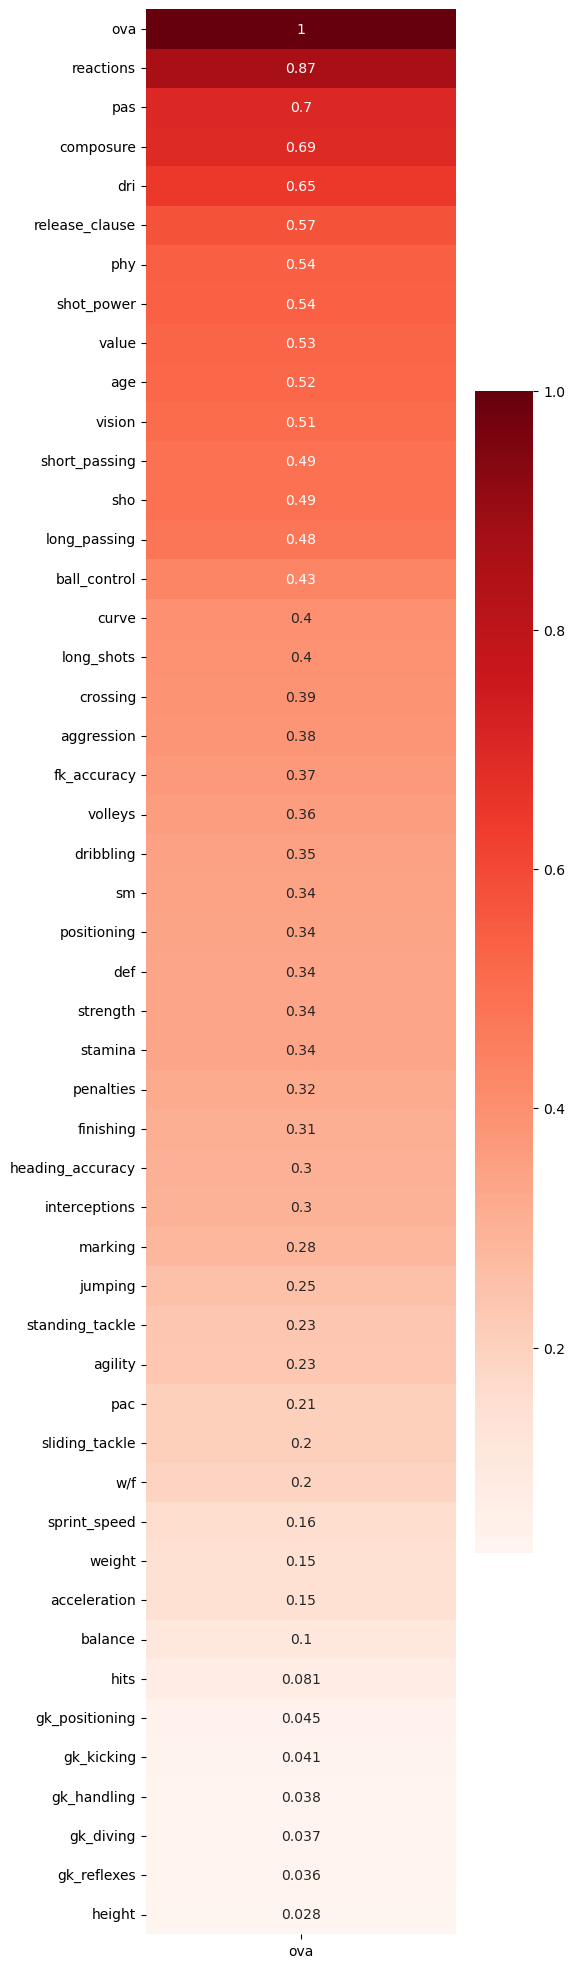

In [23]:
corr = fifanew.corr().loc[:,['ova']]
fig, ax = plt.subplots(figsize=(5,25))
ax = sns.heatmap(corr.sort_values(by=['ova'],ascending=False), ax=ax,annot=True,cbar=True,cmap="Reds")
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10)
plt.show()

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/2193423745.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = round(fifanew.corr(),2)


<Axes: >

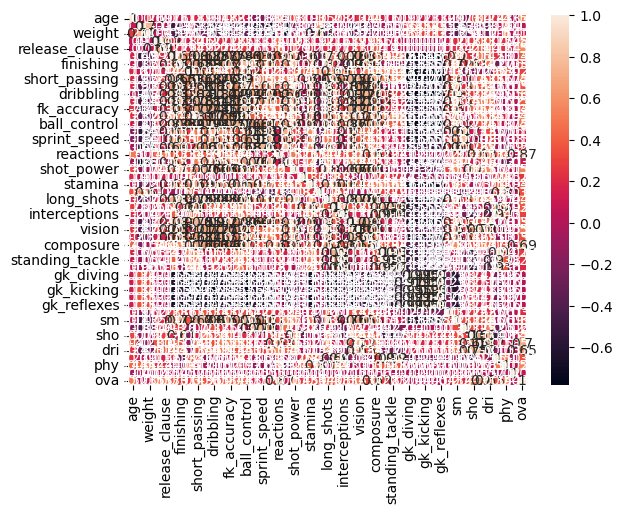

In [24]:
#correlation heat map

correlation = round(fifanew.corr(),2)
sns.heatmap(correlation, annot=True)

# x/y split

In [25]:
y = fifanew['ova']
X = fifanew.drop(['ova'], axis=1)

# Cat/num Split

In [26]:
X_num = X.select_dtypes(include=[np.number])
X_cat = X.select_dtypes(include=[object])

# Standardize numerical

In [27]:
transformer = MinMaxScaler().fit(X_num)
X_normalized = transformer.transform(X_num)
print(X_normalized.shape)
X_normalized
X_num_minmax = pd.DataFrame(X_normalized, columns=X_num.columns)

(11701, 48)


In [28]:
X_num_minmax

,age,height,weight,value,release_clause,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,fk_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,w/f,sm,pac,sho,pas,dri,def,phy,hits
0,0.370370,0.40,0.349206,0.000724,0.000481,0.545455,0.478261,0.431818,0.720930,0.465116,0.615385,0.444444,0.561798,0.642857,0.637363,0.607143,0.729412,0.573171,0.583333,0.812500,0.602410,0.685714,0.694118,0.454545,0.455556,0.517241,0.522222,0.638298,0.682353,0.534884,0.500000,0.516854,0.595238,0.440476,0.067416,0.116279,0.139535,0.076923,0.056180,0.75,0.25,0.614286,0.447368,0.558824,0.522388,0.506494,0.500000,0.000000
1,0.518519,0.55,0.333333,0.117241,0.000000,0.681818,0.826087,0.806818,0.697674,0.837209,0.857143,0.822222,0.752809,0.642857,0.813187,0.833333,0.847059,0.902439,0.708333,0.725000,0.746988,0.800000,0.741176,0.701299,0.711111,0.517241,0.311111,0.808511,0.729412,0.790698,0.690476,0.359551,0.166667,0.190476,0.112360,0.058140,0.139535,0.054945,0.168539,0.50,0.75,0.814286,0.763158,0.632353,0.805970,0.272727,0.666667,0.000446
2,0.629630,0.15,0.134921,0.012414,0.091892,0.761364,0.793478,0.329545,0.813953,0.825581,0.879121,0.944444,0.966292,0.773810,0.879121,0.845238,0.764706,0.963415,0.750000,0.950000,0.807229,0.128571,0.741176,0.285714,0.822222,0.758621,0.233333,0.829787,0.800000,0.755814,0.833333,0.224719,0.273810,0.261905,0.056180,0.011628,0.046512,0.010989,0.022472,0.75,0.75,0.771429,0.789474,0.779412,0.865672,0.194805,0.439394,0.000761
3,0.222222,0.45,0.277778,0.000379,0.000417,0.431818,0.423913,0.602273,0.627907,0.372093,0.538462,0.411111,0.460674,0.571429,0.615385,0.488095,0.564706,0.548780,0.430556,0.475000,0.542169,0.500000,0.611765,0.493506,0.377778,0.597701,0.577778,0.308511,0.517647,0.534884,0.428571,0.584270,0.619048,0.583333,0.078652,0.081395,0.046512,0.054945,0.123596,0.25,0.25,0.442857,0.355263,0.426471,0.432836,0.584416,0.500000,0.000043
4,0.259259,0.50,0.261905,0.001000,0.008408,0.488636,0.369565,0.636364,0.697674,0.348837,0.648352,0.444444,0.449438,0.619048,0.670330,0.630952,0.647059,0.573171,0.527778,0.650000,0.590361,0.128571,0.811765,0.532468,0.433333,0.655172,0.611111,0.563830,0.635294,0.476744,0.547619,0.617978,0.654762,0.714286,0.078652,0.081395,0.151163,0.032967,0.157303,0.25,0.50,0.571429,0.355263,0.514706,0.537313,0.623377,0.590909,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11696,0.333333,0.60,0.404762,0.000862,0.000535,0.636364,0.228261,0.522727,0.593023,0.279070,0.571429,0.500000,0.269663,0.535714,0.593407,0.773810,0.729412,0.658537,0.402778,0.550000,0.228916,0.671429,0.764706,0.623377,0.233333,0.620690,0.600000,0.521277,0.517647,0.360465,0.404762,0.629213,0.690476,0.654762,0.134831,0.139535,0.139535,0.043956,0.146067,0.50,0.25,0.700000,0.144737,0.455882,0.462687,0.623377,0.636364,0.000000
11697,0.407407,0.60,0.452381,0.022069,0.017417,0.068182,0.119565,0.090909,0.244186,0.139535,0.131868,0.122222,0.157303,0.214286,0.142857,0.321429,0.341176,0.292683,0.569444,0.462500,0.457831,0.485714,0.200000,0.571429,0.122222,0.241379,0.188889,0.138298,0.058824,0.127907,0.523810,0.101124,0.119048,0.083333,0.797753,0.755814,0.744186,0.747253,0.797753,0.25,0.00,0.657143,0.657895,0.602941,0.656716,0.363636,0.651515,0.000000
11698,0.222222,0.25,0.206349,0.015172,0.010210,0.659091,0.684783,0.522727,0.651163,0.430233,0.725275,0.588889,0.370787,0.583333,0.681319,0.761905,0.764706,0.878049,0.527778,0.875000,0.590361,0.657143,0.611765,0.220779,0.455556,0.206897,0.222222,0.680851,0.564706,0.662791,0.547619,0.382022,0.071429,0.083333,0.134831,0.093023,0.104651,0.054945,0.168539,0.50,0.50,0.714286,0.565789,0.514706,0.

# Standardize categoricals

In [29]:
X_cat

,bp,foot,a/w,d/w
0,CM,Right,High,Medium
1,ST,Right,High,Low
2,CAM,Right,High,Medium
3,CDM,Right,Medium,Medium
4,CDM,Right,Low,Medium
...,...,...,...,...
11696,LB,Left,Medium,Medium
11697,GK,Right,Medium,Medium
11698,RM,Right,High,Medium
11699,CM,Right,Medium,Medium


In [30]:
X_cat_ordinal = X_cat[['a/w', 'd/w']]
X_cat_ohe = X_cat[['bp', 'foot']]

In [31]:
encoder = OneHotEncoder(drop='first').fit(X_cat_ohe)
encoded = encoder.transform(X_cat_ohe).toarray()
cols = encoder.get_feature_names_out(input_features=X_cat_ohe.columns)
onehot_encoded = pd.DataFrame(encoded, columns=cols)
X_cat_encoded = onehot_encoded

In [32]:
X_cat_encoded

,bp_CB,bp_CDM,bp_CF,bp_CM,bp_GK,bp_LB,bp_LM,bp_LW,bp_LWB,bp_RB,bp_RM,bp_RW,bp_RWB,bp_ST,foot_Right
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11696,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11697,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
11699,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [33]:
X_cat_ordinal 

,a/w,d/w
0,High,Medium
1,High,Low
2,High,Medium
3,Medium,Medium
4,Low,Medium
...,...,...
11696,Medium,Medium
11697,Medium,Medium
11698,High,Medium
11699,Medium,Medium


In [34]:
X_cat_ordinal['a/w'] = X_cat_ordinal['a/w'].map({'High':1, 'Medium':0.5, 'Low':0 })
X_cat_ordinal['d/w'] = X_cat_ordinal['d/w'].map({'High':1, 'Medium':0.5, 'Low':0 })

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/332234109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat_ordinal['a/w'] = X_cat_ordinal['a/w'].map({'High':1, 'Medium':0.5, 'Low':0 })
/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/332234109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat_ordinal['d/w'] = X_cat_ordinal['d/w'].map({'High':1, 'Medium':0.5, 'Low':0 })


In [35]:
X_cat_ordinal 

,a/w,d/w
0,1.0,0.5
1,1.0,0.0
2,1.0,0.5
3,0.5,0.5
4,0.0,0.5
...,...,...
11696,0.5,0.5
11697,0.5,0.5
11698,1.0,0.5
11699,0.5,0.5


# Concat

In [36]:
X_cat_transform = pd.concat([X_cat_ordinal, X_cat_encoded], axis=1)

In [37]:
X_cat_transform

,a/w,d/w,bp_CB,bp_CDM,bp_CF,bp_CM,bp_GK,bp_LB,bp_LM,bp_LW,bp_LWB,bp_RB,bp_RM,bp_RW,bp_RWB,bp_ST,foot_Right
0,1.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11696,0.5,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11697,0.5,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11698,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
11699,0.5,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
X_transform = pd.concat([X_cat_transform, X_num_minmax], axis=1)

In [39]:
X_transform 

,a/w,d/w,bp_CB,bp_CDM,bp_CF,bp_CM,bp_GK,bp_LB,bp_LM,bp_LW,bp_LWB,bp_RB,bp_RM,bp_RW,bp_RWB,bp_ST,foot_Right,age,height,weight,value,release_clause,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,fk_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,w/f,sm,pac,sho,pas,dri,def,phy,hits
0,1.0,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.370370,0.40,0.349206,0.000724,0.000481,0.545455,0.478261,0.431818,0.720930,0.465116,0.615385,0.444444,0.561798,0.642857,0.637363,0.607143,0.729412,0.573171,0.583333,0.812500,0.602410,0.685714,0.694118,0.454545,0.455556,0.517241,0.522222,0.638298,0.682353,0.534884,0.500000,0.516854,0.595238,0.440476,0.067416,0.116279,0.139535,0.076923,0.056180,0.75,0.25,0.614286,0.447368,0.558824,0.522388,0.506494,0.500000,0.000000
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.518519,0.55,0.333333,0.117241,0.000000,0.681818,0.826087,0.806818,0.697674,0.837209,0.857143,0.822222,0.752809,0.642857,0.813187,0.833333,0.847059,0.902439,0.708333,0.725000,0.746988,0.800000,0.741176,0.701299,0.711111,0.517241,0.311111,0.808511,0.729412,0.790698,0.690476,0.359551,0.166667,0.190476,0.112360,0.058140,0.139535,0.054945,0.168539,0.50,0.75,0.814286,0.763158,0.632353,0.805970,0.272727,0.666667,0.000446
2,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.629630,0.15,0.134921,0.012414,0.091892,0.761364,0.793478,0.329545,0.813953,0.825581,0.879121,0.944444,0.966292,0.773810,0.879121,0.845238,0.764706,0.963415,0.750000,0.950000,0.807229,0.128571,0.741176,0.285714,0.822222,0.758621,0.233333,0.829787,0.800000,0.755814,0.833333,0.224719,0.273810,0.261905,0.056180,0.011628,0.046512,0.010989,0.022472,0.75,0.75,0.771429,0.789474,0.779412,0.865672,0.194805,0.439394,0.000761
3,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.222222,0.45,0.277778,0.000379,0.000417,0.431818,0.423913,0.602273,0.627907,0.372093,0.538462,0.411111,0.460674,0.571429,0.615385,0.488095,0.564706,0.548780,0.430556,0.475000,0.542169,0.500000,0.611765,0.493506,0.377778,0.597701,0.577778,0.308511,0.517647,0.534884,0.428571,0.584270,0.619048,0.583333,0.078652,0.081395,0.046512,0.054945,0.123596,0.25,0.25,0.442857,0.355263,0.426471,0.432836,0.584416,0.500000,0.000043
4,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.259259,0.50,0.261905,0.001000,0.008408,0.488636,0.369565,0.636364,0.697674,0.348837,0.648352,0.444444,0.449438,0.619048,0.670330,0.630952,0.647059,0.573171,0.527778,0.650000,0.590361,0.128571,0.811765,0.532468,0.433333,0.655172,0.611111,0.563830,0.635294,0.476744,0.547619,0.617978,0.654762,0.714286,0.078652,0.081395,0.151163,0.032967,0.157303,0.25,0.50,0.571429,0.355263,0.514706,0.537313,0.623377,0.590909,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11696,0.5,0.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.60,0.404762,0.000862,0.000535,0.636364,0.228261,0.522727,0.593023,0.279070,0.571429,0.500000,0.269663,0.535714,0.593407,0.773810,0.729412,0.658537,0.402778,0.550000,0.228916,0.671429,0.764706,0.623377,0.233333,0.620690,0.600000,0.521277,0.517647,0.360465,0.404762,0.629213,0.690476,0.654762,0.134831,0.139535,0.139535,0.043956,0.146067,0.50,0.25,0.700000,0.144737,0.455882,0.462687,0.623377,0.636364,0.000000
11697,0.5,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.407407,0.60,0.452381,0.022069,0.017417,0.068182,0.119565,0.090909,0.244186,0.139535,0.131868,0.122222,0.157303,0.214286,0.142857,0.321429,0.341176,0.292683,0.56

# train test split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_transform, y, test_size=0.2)

# Fitting the model

In [41]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

# Validating the model

In [42]:
#R2
predictions = lm.predict(X_train)
r2_score(y_train, predictions)

0.9171838610822256

In [43]:
predictions_test = lm.predict(X_test)
r2_score(y_test, predictions_test)

0.9124566688415873

In [44]:
#MSE
mse=mean_squared_error(y_test,predictions_test)
mse

4.278502934388663

In [45]:
#RMSE
rmse = np.sqrt(mean_squared_error(y_test,predictions_test))
rmse

2.0684542379247026

# Save my Model with pickle

In [47]:
fifa_model = 'finalized_model_fifa.sav'
pickle.dump(lm, open(fifa_model, 'wb'))


# Load the model from disk

In [49]:
loaded_model = pickle.load(open(fifa_model, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9124566688415873


# Test the model with other data set

In [50]:
#Reading the new data set

fifa21_2 = pd.read_csv('fifa21_validate.csv')

In [64]:
# cleaning the new data set fifa21_test2 and save it with other name

fifa21_2_clean = fifa_cleaner(fifa21_test2)

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/898252612.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x['value'] = x['value'].str.replace(".","")
/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/898252612.py:32: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x['release_clause'] = x['release_clause'].str.replace(".","")
/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/898252612.py:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  x['hits'] = x['hits'].str.replace(".

In [65]:
# x/y split

y_2 = fifa21_2_clean['ova']
X_2 = fifa21_2_clean.drop(['ova'], axis=1)

In [66]:
# Cat/num split

X_num_2 = X_2.select_dtypes(include=[np.number])
X_cat_2 = X_2.select_dtypes(include=[object])

In [67]:
# Standarize numerical

transformer_2 = MinMaxScaler().fit(X_num_2)
X_normalized_2 = transformer_2.transform(X_num_2)
print(X_normalized_2.shape)
X_normalized_2
X_num_minmax_2 = pd.DataFrame(X_normalized_2, columns=X_num_2.columns)

(1999, 48)


In [71]:
# Standarize categoricals

X_cat_ordinal_2 = X_cat_2[['a/w', 'd/w']]
X_cat_ohe_2 = X_cat_2[['bp', 'foot']]

In [72]:
encoder_2 = OneHotEncoder(drop='first').fit(X_cat_ohe_2)
encoded_2 = encoder_2.transform(X_cat_ohe_2).toarray()
cols = encoder_2.get_feature_names_out(input_features=X_cat_ohe_2.columns)
onehot_encoded_2 = pd.DataFrame(encoded_2, columns=cols)
X_cat_encoded_2 = onehot_encoded_2

In [74]:
X_cat_ordinal_2['a/w'] = X_cat_ordinal_2['a/w'].map({'High':1, 'Medium':0.5, 'Low':0 })
X_cat_ordinal_2['d/w'] = X_cat_ordinal_2['d/w'].map({'High':1, 'Medium':0.5, 'Low':0 })

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/1551378879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat_ordinal_2['a/w'] = X_cat_ordinal_2['a/w'].map({'High':1, 'Medium':0.5, 'Low':0 })
/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_15027/1551378879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat_ordinal_2['d/w'] = X_cat_ordinal_2['d/w'].map({'High':1, 'Medium':0.5, 'Low':0 })


In [76]:
# Concat categoricals

X_cat_transform_2 = pd.concat([X_cat_ordinal_2, X_cat_encoded_2], axis=1)

In [79]:
# Concat categoricals and numericals

X_transform_2 = pd.concat([X_cat_transform_2, X_num_minmax_2], axis=1)

In [81]:
#Validation model

#R2
predictions = lm.predict(X_transform_2)
r2_score(y_2, predictions)

0.8764193523847668

In [83]:
predictions_test_2 = lm.predict(X_transform_2)
r2_score(y_2, predictions_test_2)

0.8764193523847668

In [84]:
#MSE
mse=mean_squared_error(y_2,predictions_test_2)
mse

5.65523346283827

In [85]:
#RMSE

rmse_2 = np.sqrt(mean_squared_error(y_2,predictions_test_2))
rmse_2

2.3780734771739644